# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Proyecto Integrador**

### Tecnológico de Monterrey

## Actividad Semana 7

### **Actividad 5. Modelo Final**

Nombres y matrículas de los integrantes del equipo:
* Adrián Alejandro Dávila González - A01039334
* Samuel Emanuel Aguilar García - A00816565

## **Actividades Iniciales**

### **Descripción de Contexto**

Este documento se generó para realizar el procesamiento de las variables utilizadas en el entrenamiento del modelo no supervisado. Los datos procesados se guardarán en un archivo CSV que servirá como base para las etapas posteriores de entrenamiento y análisis. Este archivo CSV podrá ser abierto y utilizado en otros scripts o notebooks, permitiendo una integración sencilla en la fase de entrenamiento y otros procesos relacionados con el desarrollo del modelo.

### **Importado de Librerías a Utilizar**

In [1]:
# Montaje de Libreta en Entorno de Google Collaboratory.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the locale to UTF-8 to avoid the NotImplementedError
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
# Importado de Librerías.
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, zoom, sobel
from tabulate import tabulate
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [4]:
# Definición de Ruta en Directorios.
Main_Dir= "/content/drive/MyDrive/Maestría/Sexto Trimestre/Proyecto Integrador/Semana 7"
Temp_Dir = os.path.join(Main_Dir, "Mediciones de Temperatura/All")
OutTemp_Dir = os.path.join(Main_Dir, "Mediciones de Temperatura/New Outliers")
os.chdir(Main_Dir)

# **Datos para Modelos de Aprendizaje No Supervisado**

Se cuenta con los archivos .csv que contienen las mediciones de temperatura obtenidas por los diversos sensores de la cámara, correspondientes a cada uno de los pixeles de la imagen.

Estos archivos, a los cuáles se les ha hecho previamente diferentes funciones para preprocesamiento y análisis, son utilizados para poder obtener las características necesarias para el entrenamiento y ejecución de los modelos de aprendizaje no supervisado.

### **Procesamiento Previamente Generado**

Se aplicaron varias de las operaciones de las semanas anteriores para poder trabajar con el listado de archivos general.

In [5]:
# Procesamiento de archivos durante la apertura

# Procesos a aplicar a los archivos .csv
def process_df(df):

  # Removido de primeras dos filas debido a que contienen información irrelevante
  df= df.drop([0, 1])

  # Removido de título en el header y separación de datos a través de comas
  df = df['All temperatures in °C.'].str.split(',', expand=True)

  # Conversión a formato numérico de los datos en el dataframe
  df = df.apply(pd.to_numeric, errors='coerce')

  # Fill NaN with zeros (or another strategy)
  df = df.fillna(30)

  # Eliminado de primera columna, debido a que contiene los índices de las filas
  df = df.drop([0], axis=1)

  # Eliminado de última columna, debido a que se genera durante la apertura y no corresponde a las formas de las imágenes
  df = df.drop(df.columns[-1], axis=1)

  # Reseteo de los índices en los dataframes
  df.reset_index(drop=True, inplace=True)

  return df

In [6]:
# Inicialización de una lista vacía para guardar los DataFrames procesados y sus nombres
processed_dataframes = []
proc_dataframe_names = []
proc_out_df = []
proc_out_df_names = []

In [7]:
# Apertura de los archivos .csv en el folder Medición de Temperaturas/All

# Iteración a través de los archivos dentro del folder
for filename in os.listdir(Temp_Dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(Temp_Dir, filename)

        # Lectura de cada archivo .csv en un DataFrame
        df = pd.read_csv(file_path, encoding='utf-16', sep='\t')

        # Procesamiento del DataFrame
        processed_df = process_df(df)

        # Añadido del Dataframe a la lista de archivos procesados
        processed_dataframes.append(processed_df)

        # Añadido del nombre del Dataframe a la lista de nombres
        proc_dataframe_names.append(filename)

Además de trabajar con los archivos correspondientes a las mediciones de temperatura, se decidió generar un subconjunto de archivos con imágenes atípicas. Este subconjunto corresponde a un aproximado del 50% del dataset original.

Esto es debido a que, al observar el comportamiento del modelo base la semana anterior, se pudo inferir que existía un desbalance de clases al haber una totalidad de datos (imágenes) normales y ningún dato anómalo.

Por lo tanto, se generaron copias aleatorias de algunas imágenes del conjunto original para formar parte del conjunto de datos anómalo, el cual se escalará por un factor dentro de ciertos rangos para magnificar el efecto de los valores extremos detectados.

In [8]:
# Apertura de los archivos .csv en el folder Medición de Temperaturas/Outliers

# Iteración a través de los archivos dentro del folder
for filename in os.listdir(OutTemp_Dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(OutTemp_Dir, filename)

        # Lectura de cada archivo .csv en un DataFrame
        df = pd.read_csv(file_path, encoding='utf-16', sep='\t')

        # Procesamiento del DataFrame
        processed_df = process_df(df)

        # Añadido del Dataframe a la lista de archivos procesados
        proc_out_df.append(processed_df)

        # Añadido del nombre del Dataframe a la lista de nombres
        proc_out_df_names.append(filename)

In [9]:
# Impresión de datos estadísticos descriptivos, forma y los tipos de datos de los primeros 2 Dataframes procesados

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, processed_dataframes[:2])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Impresión de datos estadísticos descriptivos
    print(f"Descripción Estadística de los Datos del DataFrame:\n {df.describe()}"+ "\n")

    # Impresión de la forma del Dataframe y el conteo de la cantidad de pixeles por cada dimensión
    shape = df.shape
    print(f"Tamaño del DataFrame: {shape}")
    print(f"Cantidad de Pixeles en Dimensión Horizontal: {shape[1]}" + " px")
    print(f"Cantidad de Pixeles en Dimensión Vertical: {shape[0]}"+ " px\n")

    # Comprobación de los Tipos de Dato dentro del Dataframe
    print(f"Tipo de Dato en Eje X: {df.columns.dtype}")
    print(f"Tipo de Dato en Eje Y: {df.index.dtype}")
    print(f"Tipo de Dato en Eje Z: {df.values.dtype}")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_00628.csv

DataFrame 1:

Descripción Estadística de los Datos del DataFrame:
              1          2          3          4          5          6    \
count  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   22.004444  21.846667  21.814444  21.815556  21.831111  21.792222   
std     0.348645   0.380479   0.357444   0.355664   0.332726   0.313812   
min    21.300000  21.300000  21.300000  21.300000  21.300000  21.300000   
25%    21.800000  21.600000  21.600000  21.600000  21.625000  21.600000   
50%    22.000000  21.800000  21.700000  21.700000  21.800000  21.700000   
75%    22.100000  22.000000  21.900000  21.900000  21.900000  21.900000   
max    23.400000  23.600000  23.400000  23.400000  23.300000  23.200000   

            7         8          9          10   ...        111        112  \
count  90.00000  90.00000  90.000000  90.000000  ...  90.000000  90.000000   
mean   21.77000  21.74000  21.717778  21.688889  ...  22.405556  22.331111

In [10]:
# Impresión de estadísticas principales de los primeros 2 Dataframes procesados

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, processed_dataframes[:2])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Aplanado del Dataframe a una Serie de 1D y conversión a una serie de Pandas
    flattened_data = df.values.flatten()
    flattened_series = pd.Series(flattened_data)

    # Cálculo del máximo, mínimo, promedio, desviación estándar, asímetria y curtosis de las Temperaturas Medidas
    max_value = df.max().max()  # Valor Máximo en el DataFrame
    min_value = df.min().min()  # Valor Mínimo en el DataFrame
    mean_value = df.mean().mean()  # Valor Promedio en el DataFrame
    std_dev = df.std().mean()  # Desviación Estándar en el DataFrame
    skewness = flattened_series.skew() # Asimetría en el DataFrame
    kurtosis = flattened_series.kurt() # Curtosis en el DataFrame

    # Impresión de Resultados
    print(f"Valor Máximo: {max_value}"+ " °C")
    print(f"Valor Mínimo: {min_value}"+ " °C")
    print(f"Valor Promedio: {mean_value:.2f}"+ " °C")
    print(f"Desviación Estándar: {std_dev:.2f}")
    print(f"Asimetría: {skewness:.2f}")
    print(f"Curtosis: {kurtosis:.2f}")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_00628.csv

DataFrame 1:

Valor Máximo: 41.8 °C
Valor Mínimo: 20.7 °C
Valor Promedio: 21.98 °C
Desviación Estándar: 0.65
Asimetría: 9.34
Curtosis: 146.10


2. Filename: IR_00130.csv

DataFrame 2:

Valor Máximo: 28.0 °C
Valor Mínimo: 20.2 °C
Valor Promedio: 21.68 °C
Desviación Estándar: 0.59
Asimetría: 2.21
Curtosis: 7.71




In [11]:
# Inicialización de listas vacías para guardar los valores de los DataFrames que pertenecen a los ejes de las gráficas
X_list = []
Y_list = []
Z_list = []

In [12]:
# Iteración a través de los dataframes procesados
for df in processed_dataframes:
  # Creación de los vectores del grid (X,Y) basado en las columnas e índices del DataFrame, con una conversión de tipos de datos incluida.
  # Esta conversión se considera para poder hacer uso del grid correctamente al intentar graficarlo.
  X, Y = np.meshgrid(df.columns.astype(float), df.index.astype(float))

  # Creación de Z, correspondiente a los valores de temperatura en el DataFrame.
  Z = df.values

  # Añadido de los vectores a la lista de vectores para graficado
  X_list.append(X)
  Y_list.append(Y)
  Z_list.append(Z)

In [13]:
# Definición de Función para visualizar datos en 2D

def Surf2D(df,X,Y,Z):
    # Creación de un contorno relleno para graficar el Dataframe de dos dimensiones.
    # Se toma en cuenta la escala de colores "Inferno" nuevamente.
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, cmap='inferno')

    # Añadido de una barra de color, que representa la escala de temperatura detectada.
    plt.colorbar()

    # Ajustado de los límites de la barra de colores según los valores mínimos y máximos del Dataframe.
    plt.clim(df.min().min(), df.max().max())

    # Añadido de etiquetas correspondientes a cada eje.
    plt.xlabel('X (Pixeles)')
    plt.ylabel('Y (Pixeles)')
    plt.title('Gráfico de Contorno por Temperatura en 2D')

    # Mostrado del gráfico.
    plt.show()

In [14]:
# Definición de Función para visualizar datos en 3D

def Surf3D(df,X,Y,Z):
    # Generación del gráfico en 3D
    fig = plt.figure(figsize=(14, 10))  # Tamaño arbitrario. Puede ajustarse.
    ax = fig.add_subplot(111, projection='3d')

    # Graficado de la gráfica de superficie, con un mapa de colores ("Inferno") equivalente a la escala de colores "Ironbow" en la que se aprecian
    # los filtros infrarrojos en las imágenes a procesar.
    surf = ax.plot_surface(X, Y, Z, cmap='inferno')

    # Añadido de una barra de color, que representa la escala de temperatura detectada.
    cbar = fig.colorbar(surf)

    # Ajustado de los límites de la barra de colores según los valores mínimos y máximos del Dataframe.
    surf.set_clim(df.min().min(), df.max().max())

    # Añadido de etiquetas correspondientes a cada eje.
    ax.set_xlabel('X (Pixeles)')
    ax.set_ylabel('Y (Pixeles)')
    ax.set_zlabel('Temperatura (°C)')

    # Mostrado del gráfico.
    plt.show()

1. Filename: IR_00628.csv

DataFrame 1:



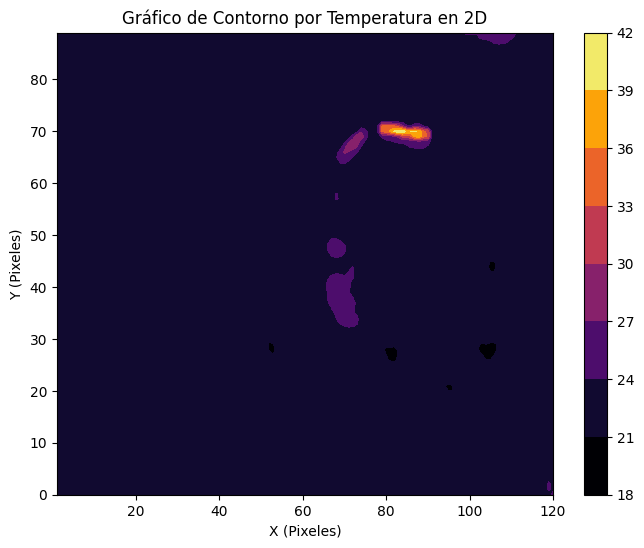

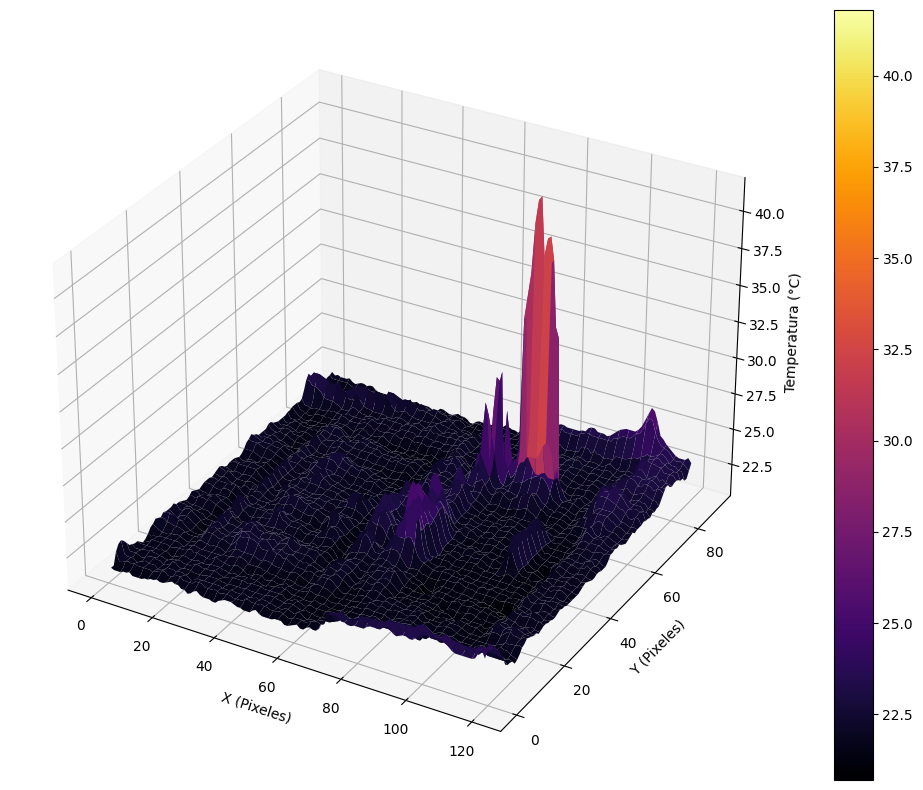



2. Filename: IR_00130.csv

DataFrame 2:



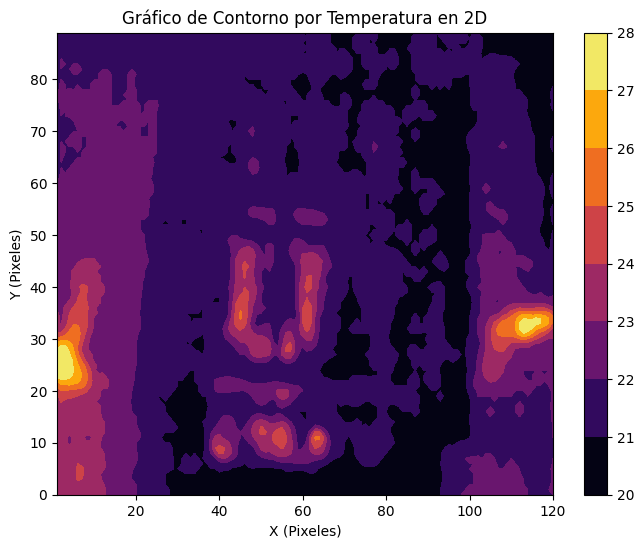

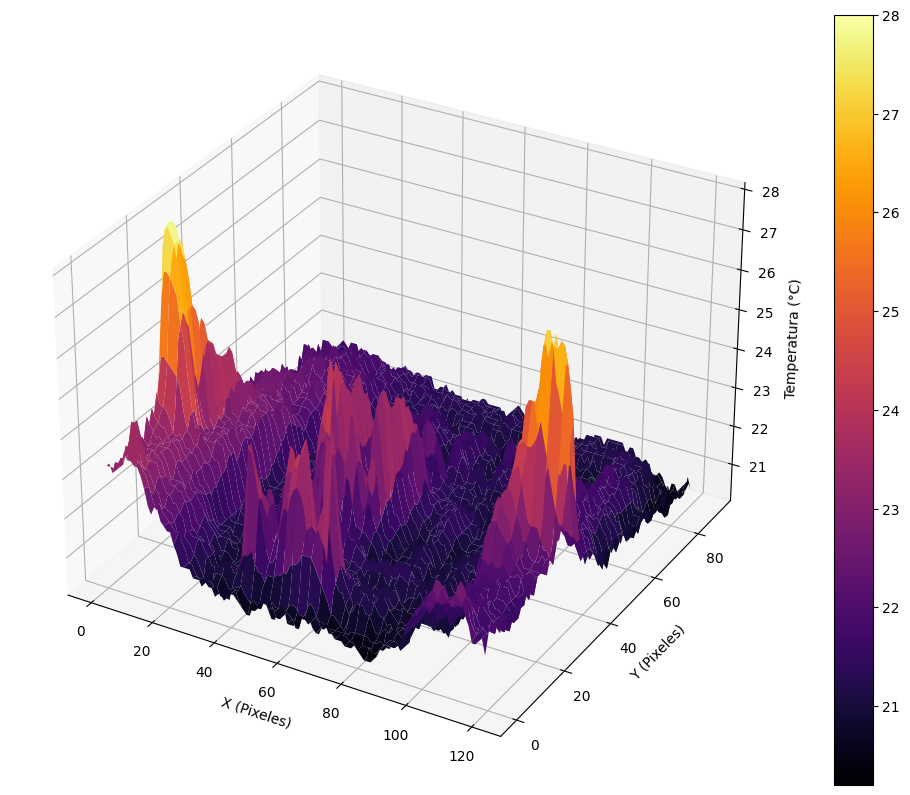



3. Filename: IR_00475.csv

DataFrame 3:



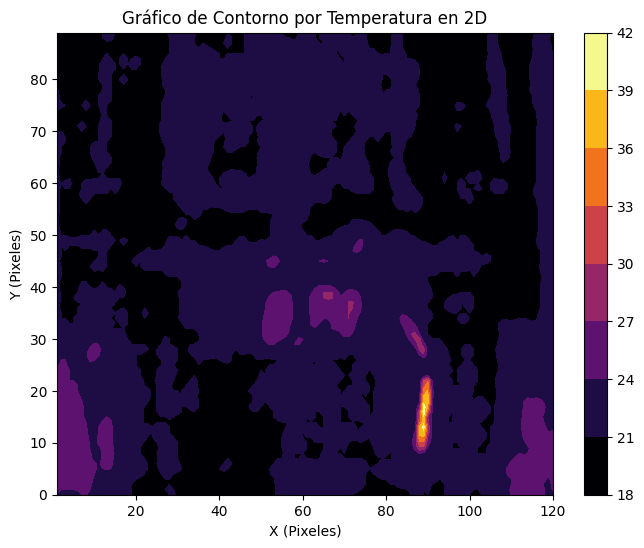

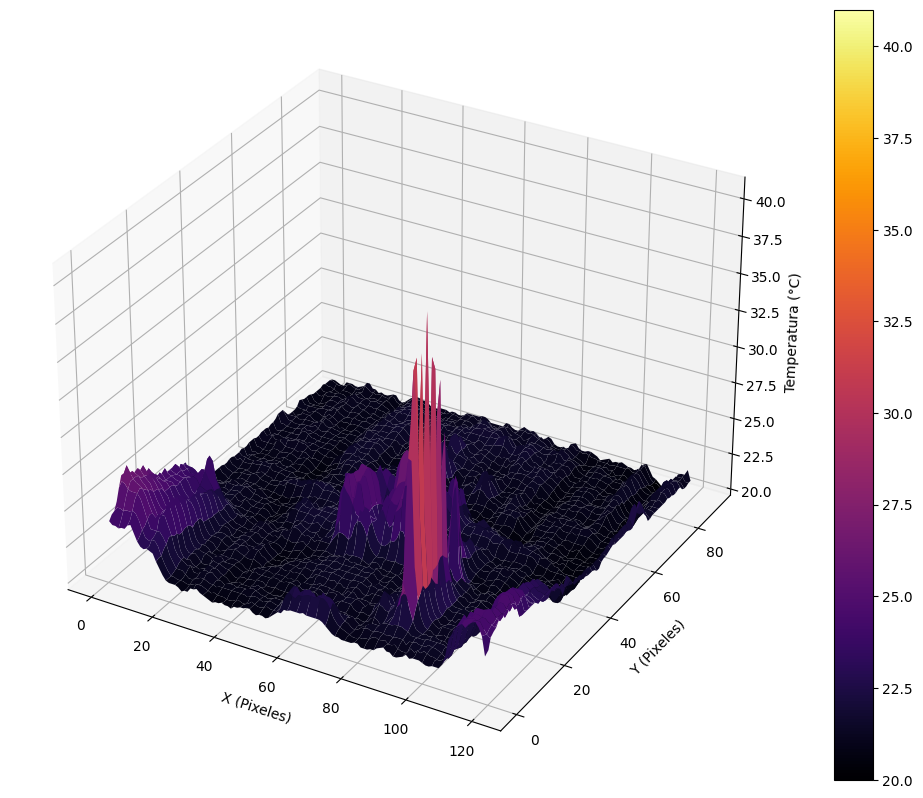



4. Filename: IR_01776.csv

DataFrame 4:



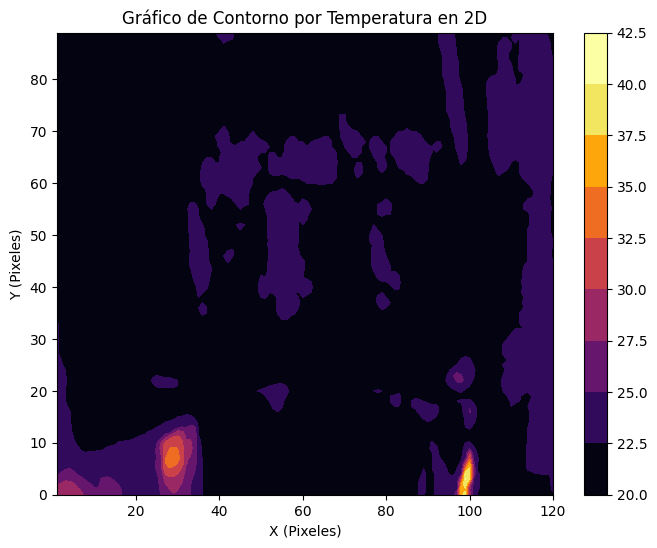

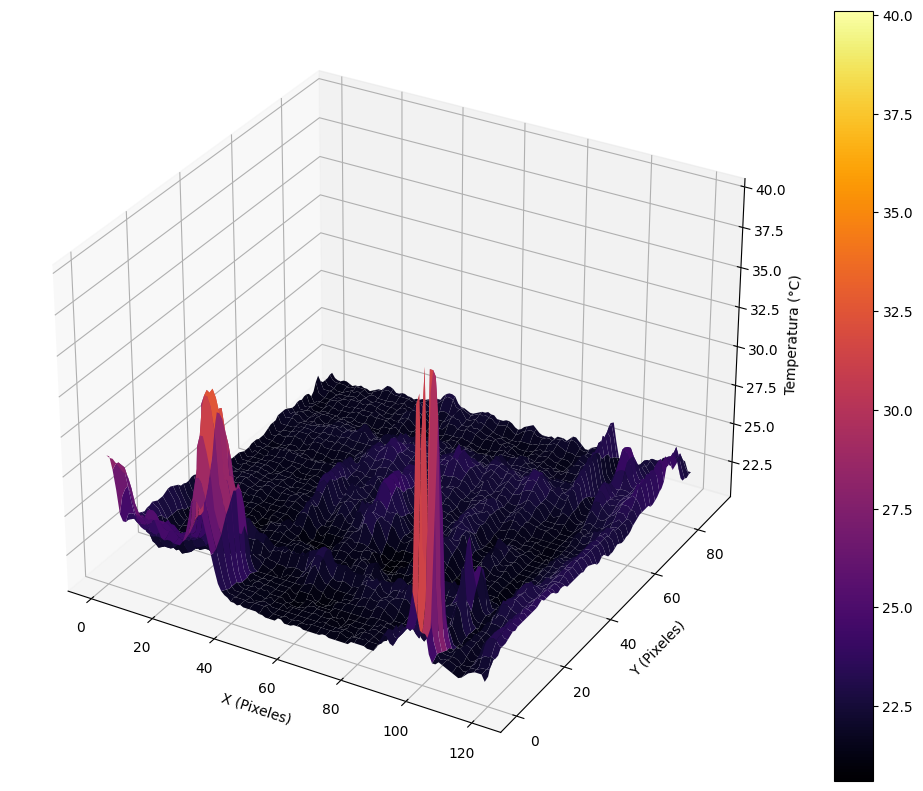



5. Filename: IR_00056.csv

DataFrame 5:



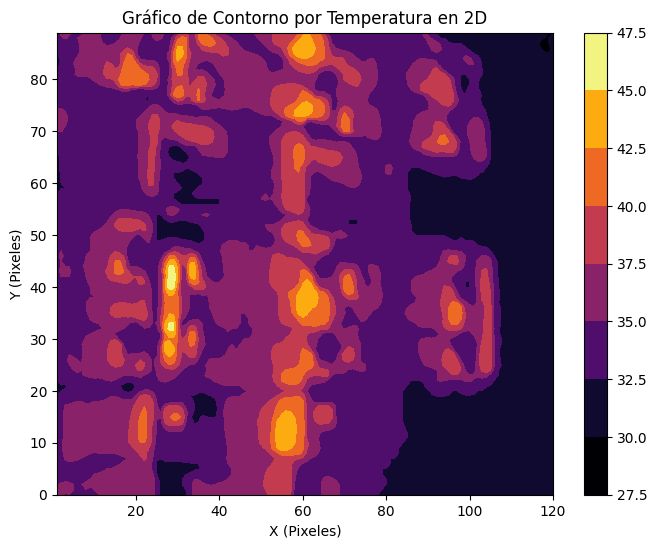

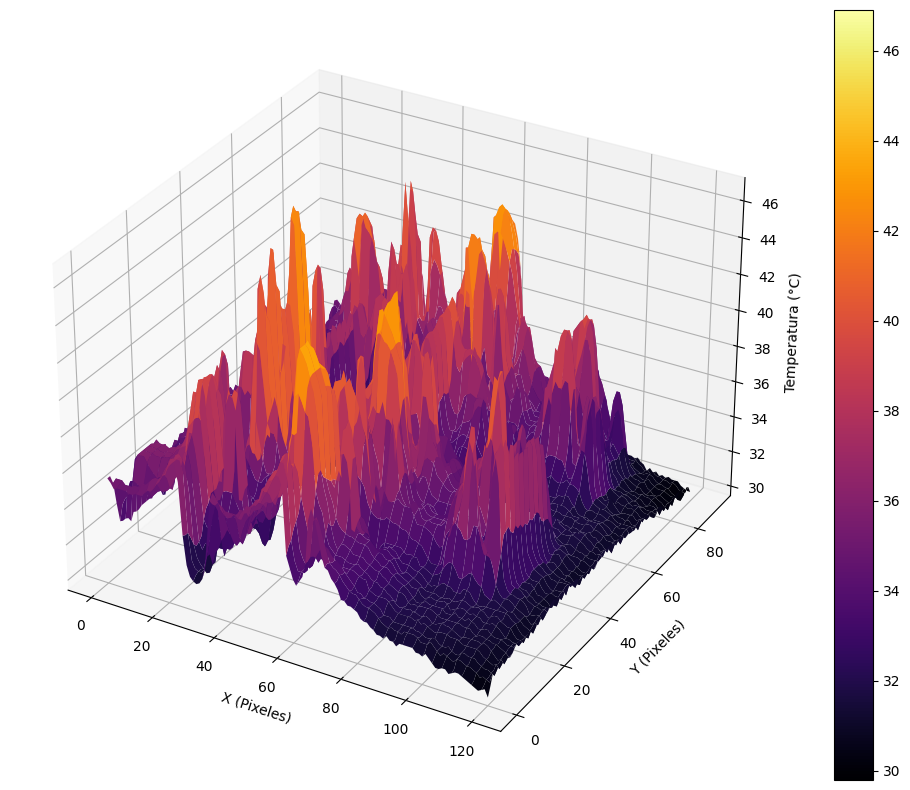

In [15]:
# Impresión de mapas de superficie con las mediciones de temperatura obtenidas

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, processed_dataframes[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Impresión de mapa de contorno en 2D de las temperaturas medidas
    Surf2D(df, X_list[i], Y_list[i], Z_list[i])
    print("\n")

    # Impresión de mapa de superficie en 3D de las temperaturas medidas
    Surf3D(df, X_list[i], Y_list[i], Z_list[i])

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

### **Funciones para Aplicación sobre listado de archivos**

### **Construcción de Nuevas Características**

Como se mencionó anteriormente se decidió generar la siguiente característica, para solventar el problema de desbalance de clases con el que se contaba originalmente:

1.   Dataframe con banderas binarias (*binary flags*) correspondientes a los valores atípicos o extremos en las mediciones de temperatura

**Valores Atípicos o Extremos (Anomalías)**

Se llevó a cabo la generación del dataframe con los valores atípicos, siguiendo la siguiente forma:

**Outlier i,j** =
*   *{1, if Ti,j > Tmean + 3×σ}*
*   *{1, if Ti,j < Tmean - 3×σ}*
*   *{0, otherwise}*

In [16]:
# Creación de Matriz Binaria relacionada a los valores atípicos con respecto a los límites

def outliers (df, mean_value, std_dev):
  # Asignación de valores a las variables para el promedio y desviación estándar de la imagen ejemplo
  mean_temp = mean_value
  std_temp = std_dev

  # Definición de los límites superior e inferior para los valores atípicos
  upper_thrs = mean_temp + 3 * std_temp
  lower_thrs = mean_temp - 3 * std_temp

  # Creación de una matriz binaria
  outliers = pd.DataFrame(np.where(df > upper_thrs, 1, np.where(df < lower_thrs, -1, 0)))

  # Visualización de los resultados
  print("Mapa de Valores Atípicos (1 = atípico superior, -1 = atípico inferior, 0 = normal):\n", outliers)

  return outliers

Para la generación de esta característica, se hizo uso de los datos previo a que se les aplicaran técnicas de transformación y escalamiento. Esto es debido a que se busca mantener la relación de los comportamientos, además de encontrar los puntos extremos con respecto a la escala correspondiente previa al aplicado de estas técnicas.

Además de esto, se puede apreciar que se cambió la condición para asignar el valor correspondiente a un dato típico y a un dato atípico, para poder aplicar un escalamiento diferente en los datos superiores e inferiores.

### **Estandarización y normalización**

Una vez que se generó un nuevo conjunto de datos con las banderas que corresponden a los puntos de la imagen en temperaturas atípicas o extremas, se llevó a cabo la transformación de los datos.

Originalmente, se hacia uso de la normalización min-max debido a que no se buscaba normalizar las distribuciones de los comportamientos en las imágenes.

No obstante, al observar los resultados de desempeño por parte del modelo base, se decidió sustituir esta transformación por una estandarización, además de aplicar un filtro gaussiano a los datos para reducir el impacto del ruido sobre el conjunto. Esto es de crucial importancia al contar con nuevos datos con impacto mayor a los originales en los conjuntos de atípicos generados.

In [17]:
# Transformación de datos numéricos

def normalization(df):
  # Apicación de Filtro Gaussiano a la matriz de características (X)
  sigma = 1  # Desviación estándar para el kernel Gaussiano
  df_smooth = gaussian_filter(df, sigma=sigma)

  # Estandarización de los datos
  scaler_std = StandardScaler()
  temp_norm = scaler_std.fit_transform(df_smooth)

  # Convertir de nuevo a DataFrame si es necesario
  temp_norm = pd.DataFrame(temp_norm, columns=df.columns)

  # Impresión de los resultados
  print("Dataframe Normalizado:\n",temp_norm)

  return temp_norm

### **Selección/Extracción de Características**

Para poder facilitar el proceso de entrenamiento de los modelos de agrupación, se filtró el dataframe de mediciones de temperatura al obtener los gradientes de cada pixel, considerando su magnitud y dirección.

Esto debido a que un dataframe de gradientes puede mostrar las relaciones de comportamiento en los diferentes grupos de pixeles de mejor manera qué solo las mediciones de temperaturas.

#### **Operaciones con Gradientes**

Se decidió llevó a cabo el cálculo de los gradientes en la imagen. Esto es debido a que al contar con las magnitudes, direcciones y velocidades (representadas por la varianza) de los gradientes de cada pixel en las imágenes, se pueden realizar muchas inferencias correspondientes al comportamiento de las temperaturas en la imagen, además de brindar un marco de comparación que puede ser útil previo a la definición de modelos de agrupamiento.

Además de lo anterior, se llevaron a cabo algunos cálculos estadísticos con respecto a la magnitud de los gradientes para observar la varianza de las magnitudes, junto al valor promedio.

In [18]:
# Operaciones relacionadas con gradientes

def gradient_comps(df):

  # Cálculo de los gradientes en la dirección 'x' (horizontal) y la dirección 'y' (vertical).
  grad_x = np.diff(df, axis=1)  # Gradiente a través del eje 'x'
  grad_y = np.diff(df, axis=0)  # Gradiente a través del eje 'y'

  # Debido a que np.diff reduce las dimensiones del arreglo, se aplica un relleno al resultado (padding) para que coincidan con los tamaños originales
  grad_x = np.pad(grad_x, ((0, 0), (0, 1)), mode='edge')  # Padding a la última columna
  grad_y = np.pad(grad_y, ((0, 1), (0, 0)), mode='edge')  # Padding a la última fila

  # Cálculo de la magnitud y la dirección de los gradientes
  grad_mag = np.sqrt(grad_x**2 + grad_y**2)
  grad_dir = np.arctan2(grad_y, grad_x) # En radianes, debido al uso de np.arctan2

  # Conversión de las direcciones de los gradientes de radianes a grados
  grad_dirdeg = np.degrees(grad_dir)

  # Ajuste aplicado a las direcciones para que todos los grados sean positivos
  grad_dirdeg = (grad_dirdeg + 360) % 360

  # Cálculo de la magnitud promedio de los gradientes
  avg_mag = np.mean(grad_mag)

  # Cálculo de la varianza en la magnitud de los gradientes
  var_mag = np.var(grad_mag)

  # Visualización de los resultados
  print("Gradiente por Pixel(x):\n", grad_x)
  print("\nGradiente por Pixel(y):\n", grad_y)
  print("\nMagnitud del Gradiente por Pixel:\n", grad_mag)
  print("\nDirección del Gradiente (radianes) por Pixel:\n", grad_dir)
  print("\nDirección del Gradiente (grados) por Pixel:\n", grad_dirdeg)
  print(f"\nPromedio de las Magnitudes de los Gradientes: {avg_mag:.4f}")
  print(f"\nVarianza de las Magnitudes de los Gradientes: {var_mag:.4f}")

  return grad_mag, grad_dir, grad_dirdeg

Una vez que se obtiene la información anterior, se genera una gráfica conocida como *Histogram of Gradients (HOG)* con respecto a las direcciones de los gradientes, en la cuál se pueden apreciar los patrones de movimiento de los gradientes en la imagen representada.

Es decir, se grafican las frecuencias de las direcciones hacia donde tienden los gradientes en un rango de 360° (0 - 2*pi), para encontrar la dirección hacia donde tienden los cambios de temperatura en la imagen.

Además de esto, se grafica una visualización del histograma de gradientes. Esta gráfica denota el comportamiento y la tendencia de movimiento de los gradientes de los pixeles en la imagen. El hacer uso de estos dataframes con los gradientes para complementar el proceso de comparación entre diferentes imágenes, puede ser más efectivo que solamente haciendo uso de las mediciones en cada punto.

In [19]:
# Cálculo del Histograma de Gradientes (HOG) con las direcciones de los gradientes

def HOG_dir(grad_dirdeg, bins, bin_width):
  # Cómputo del histograma de las direcciones de los gradientes
  hog, bin_edges = np.histogram(grad_dirdeg, bins=bins, range=(0, 360))

  # Impresión de los valores del histograma
  print("Histograma de las Direcciones de Gradientes (Grados):\n", hog)
  print("\n")

  # Ploteado del histograma
  plt.bar(bin_edges[:-1], hog, width=bin_width, edgecolor='black')
  plt.title('Histograma de las Direcciones de Gradientes (Grados)')
  plt.xlabel('Dirección (Grados)')
  plt.ylabel('Frecuencia')
  plt.show()

In [20]:
# Visualización del Histograma de Gradientes

def HOV_df(grad_mag, grad_dir, height, width, step):

  # Definición de las componentes de los vectores a graficar
  U = grad_mag * np.cos(grad_dir)  # Componente en X
  V = grad_mag * np.sin(grad_dir)  # Componente en Y

  # Creación de un grid para el graficado de los vectores
  X, Y = np.meshgrid(np.arange(0, width), np.arange(0, height))

  # Graficado de las flechas (vectores) del Histograma de Gradientes (HOG)
  plt.figure(figsize=(14, 14))

  # Submuestreo para una mejor visualización
  plt.quiver(X[::step, ::step], Y[::step, ::step], U[::step, ::step], V[::step, ::step],
           grad_mag[::step, ::step], angles='xy', scale_units='xy', scale=1, cmap='inferno')

  # Personalización de la gráfica
  plt.gca().invert_yaxis()  # Inversión del eje 'y' para una orientación correcta
  plt.title("Visualización del HOG")
  plt.xlabel("Eje X")
  plt.ylabel("Eje Y")
  plt.colorbar(label="Magnitud del Gradiente")  # Mostrado de la barra de colores para representar las magnitudes
  plt.show()

A diferencia de semanas anteriores, se definen listas con la terminación *_Test* para su uso en las pruebas de las funciones definidas, mientras que se liberan los nombres sin sufijo para las listas que se utilizarán de forma completa.

In [21]:
# Inicialización de listas para almacenar resultados
Outliers_Test = []
Adjusted_Temp_Test = []
Normal_Temp_Test = []
Grad_Mag_Test = []
Grad_Dir_Test = []
Grad_DirDeg_Test = []

Al contar con un conjunto de dataframes conformado por 0's, -1's y 1's correspondiente a las ubicaciones de puntos extremos o atípicos en los datos anómalos generados, se pueden utilizar como una equivalencia a coordenadas o ubicaciones para encontrar esos puntos en los dataframes generados.

Al ubicar estos puntos, se define una función para generar un par de máscaras que permitan escalar hacia arriba o hacia abajo (dependiendo del signo del 1) las mediciones de temperaturas en los nuevos datos generados.

In [22]:
# Definición de la máscara para el escalamiento de las temperaturas anómalas ("data generation")

def apply_outlier_mask(df, outlier_df, upper_range, lower_range):
    # Comprobación de la alineación de las columnas y sus índices entre ambos DataFrames
    outlier_df.columns = df.columns

    # Creación de máscaras para 1's (atípicos superiores) y -1's (atípicos inferiores)
    upper_mask = outlier_df == 1  # Máscara en donde los valores son 1
    lower_mask = outlier_df == -1  # Máscara en donde los valores son -1

    # Inicialización de un nuevo DataFrame con los mismos valores que el original
    adjusted_df = df.copy()

    # Definición de un factor de escalamiento para los rangos superiores
    Up_rg= random.uniform(*upper_range)

    # Definición de un factor de escalamiento para los rangos inferiores
    Low_rg= random.uniform(*lower_range)

    # Aplicación de los factores en base a las máscaras
    adjusted_df[upper_mask] = df[upper_mask] * Up_rg
    adjusted_df[lower_mask] = df[lower_mask] * Low_rg

    print("Temperaturas ajustadas:\n", adjusted_df)
    return adjusted_df, Up_rg, Low_rg

Se obtiene la estandarización de los datos originales y el cálculo de sus gradientes para probar los cambios realizados en el proceso.

In [23]:
# Impresión de dataframes de valores atípicos y normalizados

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, processed_dataframes[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Normalización de Dataframe y almacenamiento en la lista correspondiente
    temp_norm = normalization(df)
    Normal_Temp_Test.append(temp_norm)
    print("\n")

    # Operaciones con Gradientes y almacenamiento en la lista correspondiente
    grad_mag, grad_dir, grad_dirdeg = gradient_comps(df)
    Grad_Mag_Test.append(grad_mag)
    Grad_Dir_Test.append(grad_dir)
    Grad_DirDeg_Test.append(grad_dirdeg)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_00628.csv

DataFrame 1:

Dataframe Normalizado:
          1         2         3         4         5         6         7    \
0  -1.797100 -1.693352 -1.556579 -1.469125 -1.372923 -1.268204 -1.258727   
1  -1.244660 -1.275408 -1.207490 -1.118067 -1.023213 -0.924509 -0.874685   
2  -0.165611 -0.511075 -0.660050 -0.630939 -0.575260 -0.524790 -0.457845   
3   0.762970  0.104118 -0.304602 -0.391893 -0.425935 -0.463576 -0.392622   
4   1.057916  0.273866 -0.273415 -0.452553 -0.585377 -0.708358 -0.614011   
..       ...       ...       ...       ...       ...       ...       ...   
85 -0.536637 -0.766462 -0.917297 -1.014024 -1.151127 -1.266264 -1.332508   
86 -0.437899 -0.611236 -0.751003 -0.888888 -1.029352 -1.105974 -1.142463   
87 -0.230015 -0.344792 -0.443632 -0.558561 -0.665110 -0.702051 -0.720827   
88 -0.010705 -0.055822 -0.081509 -0.137045 -0.183210 -0.151821 -0.138520   
89  0.158370  0.163800  0.191452  0.165485  0.153159  0.245296  0.299998   

         8         9  

Se definen los rangos entre los que puede encontrarse el factor que se utilizará para escalar el dataframe ajustado previo al llamado de la función y se lleva a cabo la prueba de las funciones definidas para observar el efecto sobre el conjunto de datos ajustados de prueba.

In [24]:
# Definición de los rangos para los factores superior e inferior
upper_factor_range = (2.0, 3.0)  # Factor random entre 2.0 y 3.0
lower_factor_range = (0.5, 0.9)  # Factor random entre 0.5 y 0.9

In [25]:
# Generación de dataframes de valores atípicos y ajuste (escalamiento) de los dataframes de outliers para maximizar su impacto

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_out_df_names, proc_out_df[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Generación de Dataframe de Valores Atípicos y almacenamiento en la lista correspondiente
    outlier = outliers(df, df.mean().mean(), df.std().mean())
    Outliers_Test.append(outlier)
    print("\n")

    # Aplicación de la máscara de valores atípicos al DataFrame original
    adjusted_temp, upper_rg, lower_rg = apply_outlier_mask(df, outlier, upper_factor_range, lower_factor_range)
    print(f"Upper Factor {i + 1}: {upper_rg}"+ "\n")
    print(f"Lower Factor {i + 1}: {lower_rg}"+ "\n")
    Adjusted_Temp_Test.append(adjusted_temp)

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_92302.csv

DataFrame 1:

Mapa de Valores Atípicos (1 = atípico superior, -1 = atípico inferior, 0 = normal):
     0    1    2    3    4    5    6    7    8    9    ...  110  111  112  113  \
0     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
85    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
86    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
87    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
88    0    0    0    0    0    0    0    0    0    0  ...    0  

Al finalizar este proceso, se aplica la estandarización de los datos ajustados y el cálculo de los valores de sus gradientes.

In [26]:
# Cálculo de gradientes para las imágenes atípicas previamente procesadas y escaladas

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_out_df_names, Adjusted_Temp_Test[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Normalización de Dataframe y almacenamiento en la lista correspondiente
    temp_norm = normalization(df)
    Normal_Temp_Test.append(temp_norm)
    print("\n")

    # Operaciones con Gradientes y almacenamiento en la lista correspondiente
    grad_mag, grad_dir, grad_dirdeg = gradient_comps(df)
    Grad_Mag_Test.append(grad_mag)
    Grad_Dir_Test.append(grad_dir)
    Grad_DirDeg_Test.append(grad_dirdeg)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_92302.csv

DataFrame 1:

Dataframe Normalizado:
          1         2         3         4         5         6         7    \
0  -2.556557 -2.375626 -2.130652 -2.026524 -2.018224 -2.008075 -1.931299   
1  -2.362175 -2.160192 -1.917559 -1.819587 -1.819356 -1.844832 -1.836880   
2  -2.055941 -1.845632 -1.638595 -1.585788 -1.624049 -1.686562 -1.728604   
3  -1.709935 -1.550701 -1.415722 -1.423503 -1.508827 -1.598524 -1.654205   
4  -1.457777 -1.373622 -1.320200 -1.366042 -1.455844 -1.543632 -1.594655   
..       ...       ...       ...       ...       ...       ...       ...   
85  1.284749  1.157296  1.152630  1.291500  1.352585  1.236824  1.127177   
86  1.774905  1.600027  1.515288  1.545635  1.494603  1.317592  1.192150   
87  2.292847  2.073329  1.912701  1.862157  1.752853  1.567858  1.437222   
88  2.637534  2.395353  2.199576  2.114302  1.987761  1.802688  1.655235   
89  2.749655  2.507405  2.320918  2.241691  2.119954  1.931998  1.767518   

         8         9  

1. Filename: IR_00628.csv

DataFrame 1:

Histograma de las Direcciones de Gradientes (Grados):
 [2522  110  173   46  640   51  171   97   37 1295   92  171   44  495
   23  136   48   12 1202   74  202   54  693   54  175   74   18 1149
   72  119   29  422   37  148   95   20]




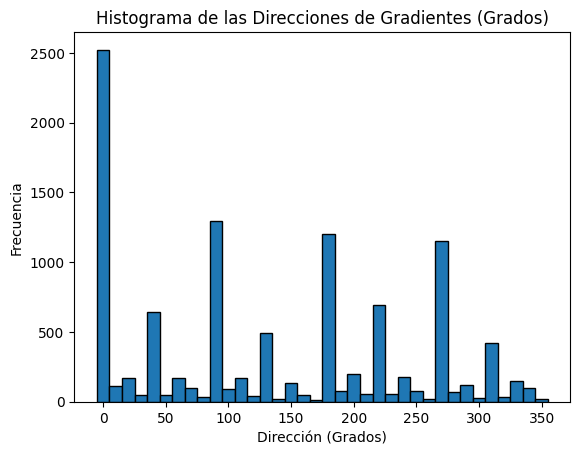





2. Filename: IR_00130.csv

DataFrame 2:

Histograma de las Direcciones de Gradientes (Grados):
 [2983  127  133   39  537   37   97   77   20 1014   92  152   46  351
   36  172   96   18 1436  117  196  103  741   60  152   80   20 1006
   50   98   27  289   40  175  146   37]




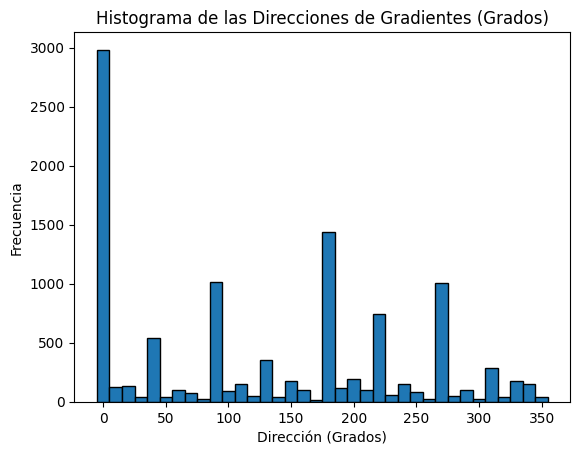





3. Filename: IR_00475.csv

DataFrame 3:

Histograma de las Direcciones de Gradientes (Grados):
 [2307  151  182   61  662   58  187  100   14 1035   84  162   47  391
   58  170  106   24 1223  186  271   87  689   84  169  124   29  976
   82  155   46  393   62  192  166   67]




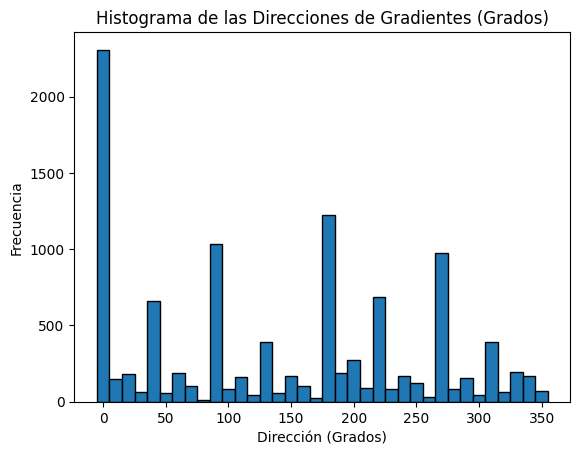





4. Filename: IR_01776.csv

DataFrame 4:

Histograma de las Direcciones de Gradientes (Grados):
 [2923  178  220   62  583   46  164   83    6 1049   71  161   43  367
   47  170  120   32 1150  170  227   87  578   64  151   72    8  960
  103  140   55  341   36  173  131   29]




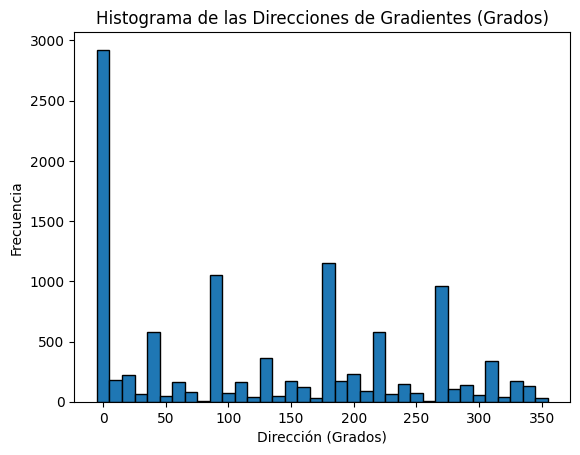





5. Filename: IR_00056.csv

DataFrame 5:

Histograma de las Direcciones de Gradientes (Grados):
 [1499  242  198  134  424  192  245  243  144  846  205  240  114  367
  121  181  148  103  987  219  231  180  474  178  245  226  111  729
  178  198  157  280  164  191  248  158]




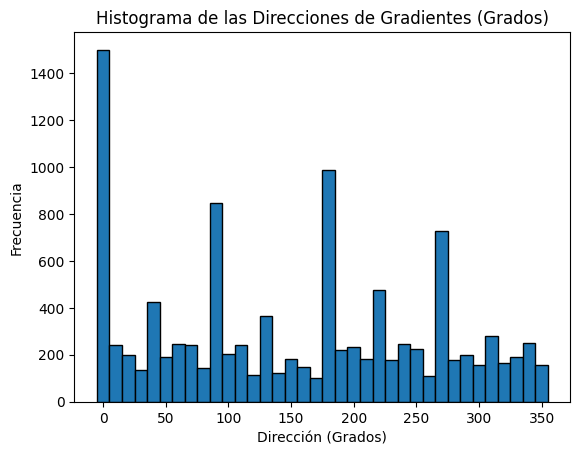

In [27]:
# Impresión de histogramas de las direcciones de los gradientes de los dataframes

# Definición del número de 'bins'
num_bins = 36  # Para generar intervalos de 10 grados, al estar las direcciones en grados

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, Normal_Temp_Test[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Graficado de los Histogramas de las Direcciones de Gradientes
    HOG_dir(Grad_DirDeg_Test[i], num_bins, 10)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

1. Filename: IR_00628.csv

DataFrame 1:



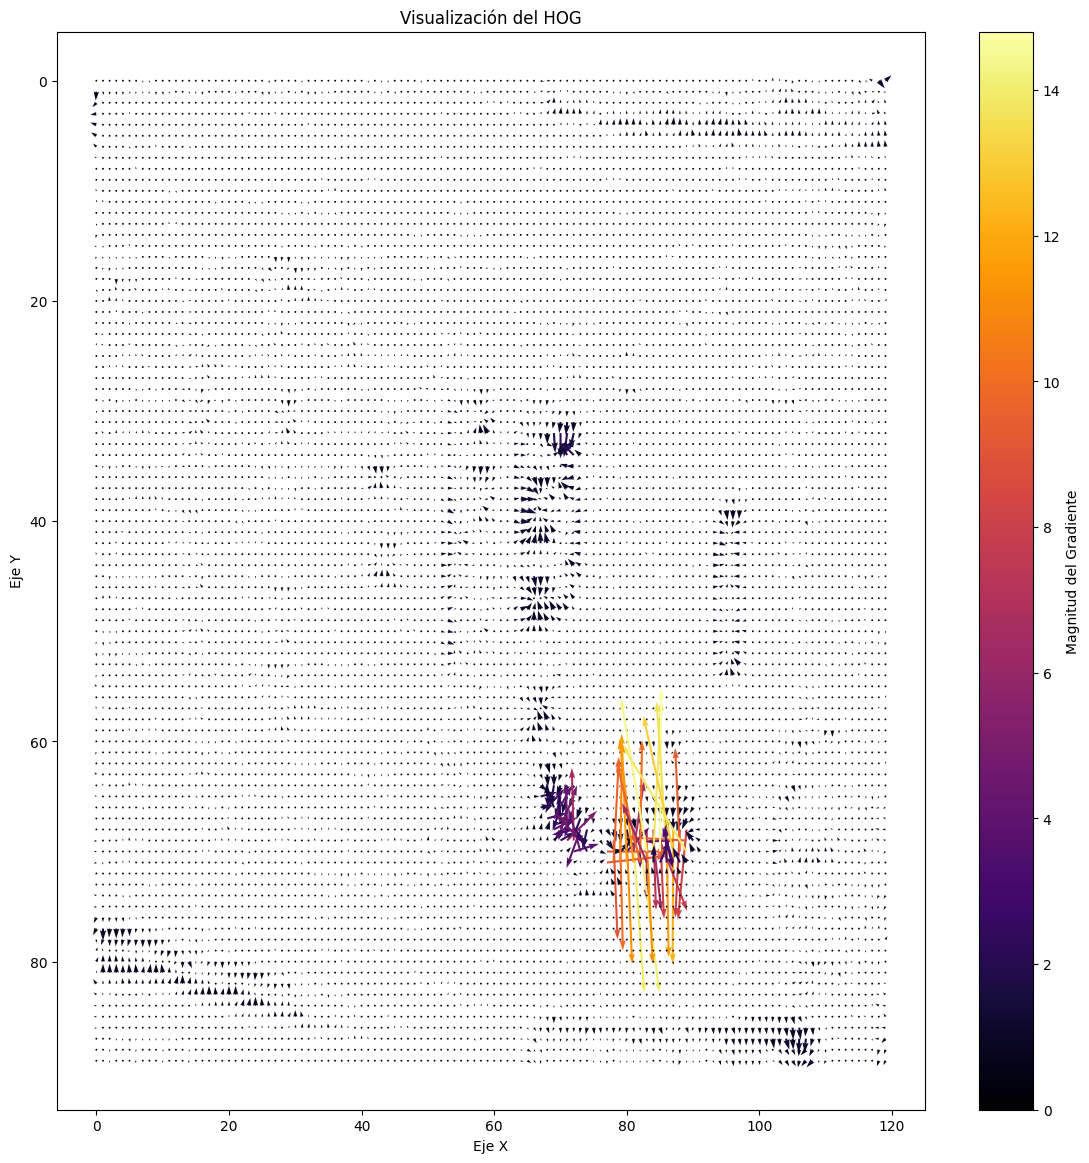





2. Filename: IR_00130.csv

DataFrame 2:



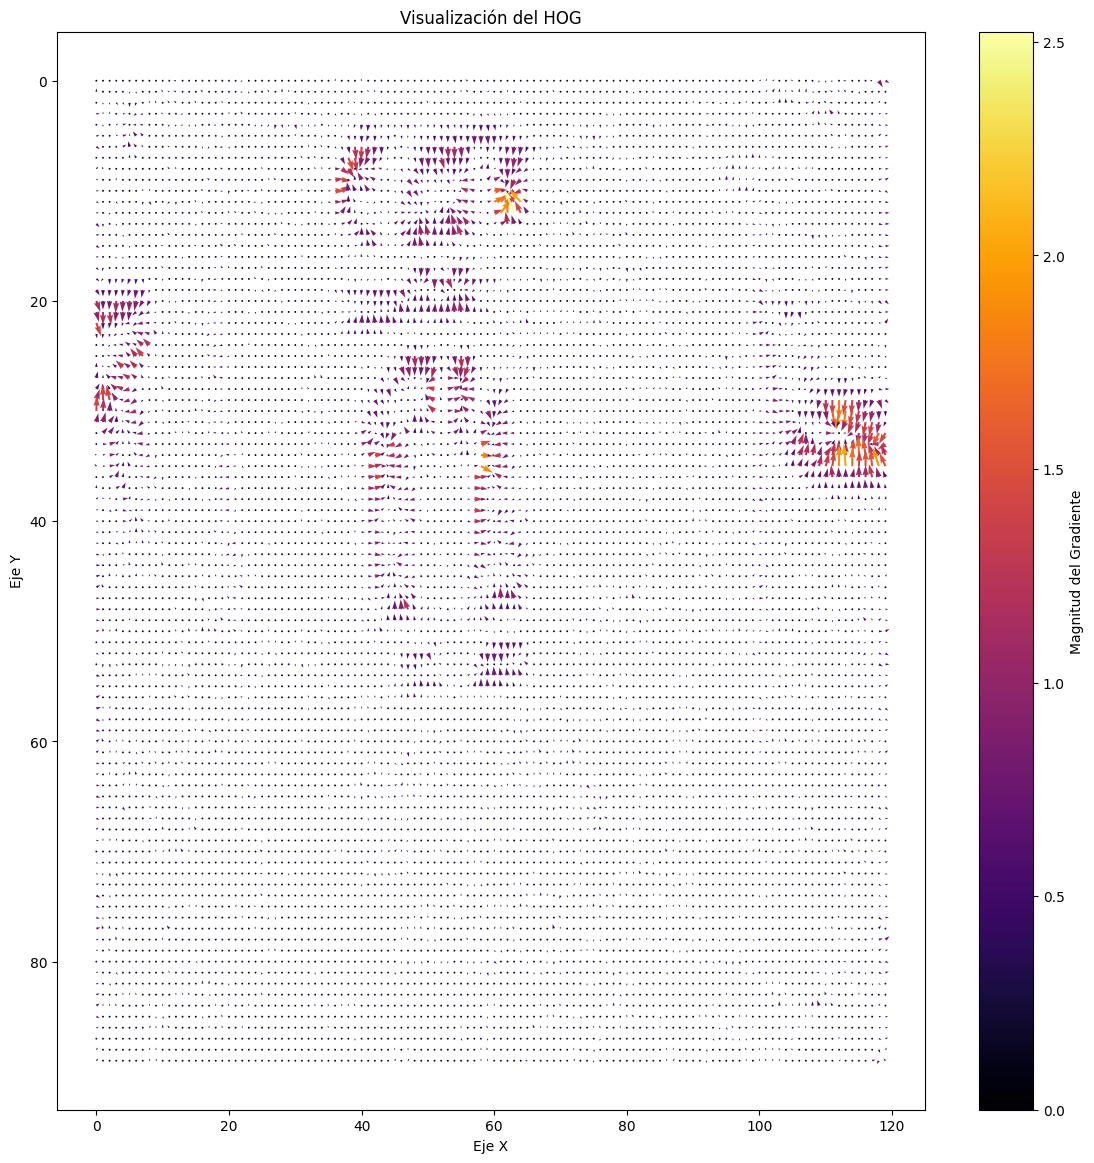





3. Filename: IR_00475.csv

DataFrame 3:



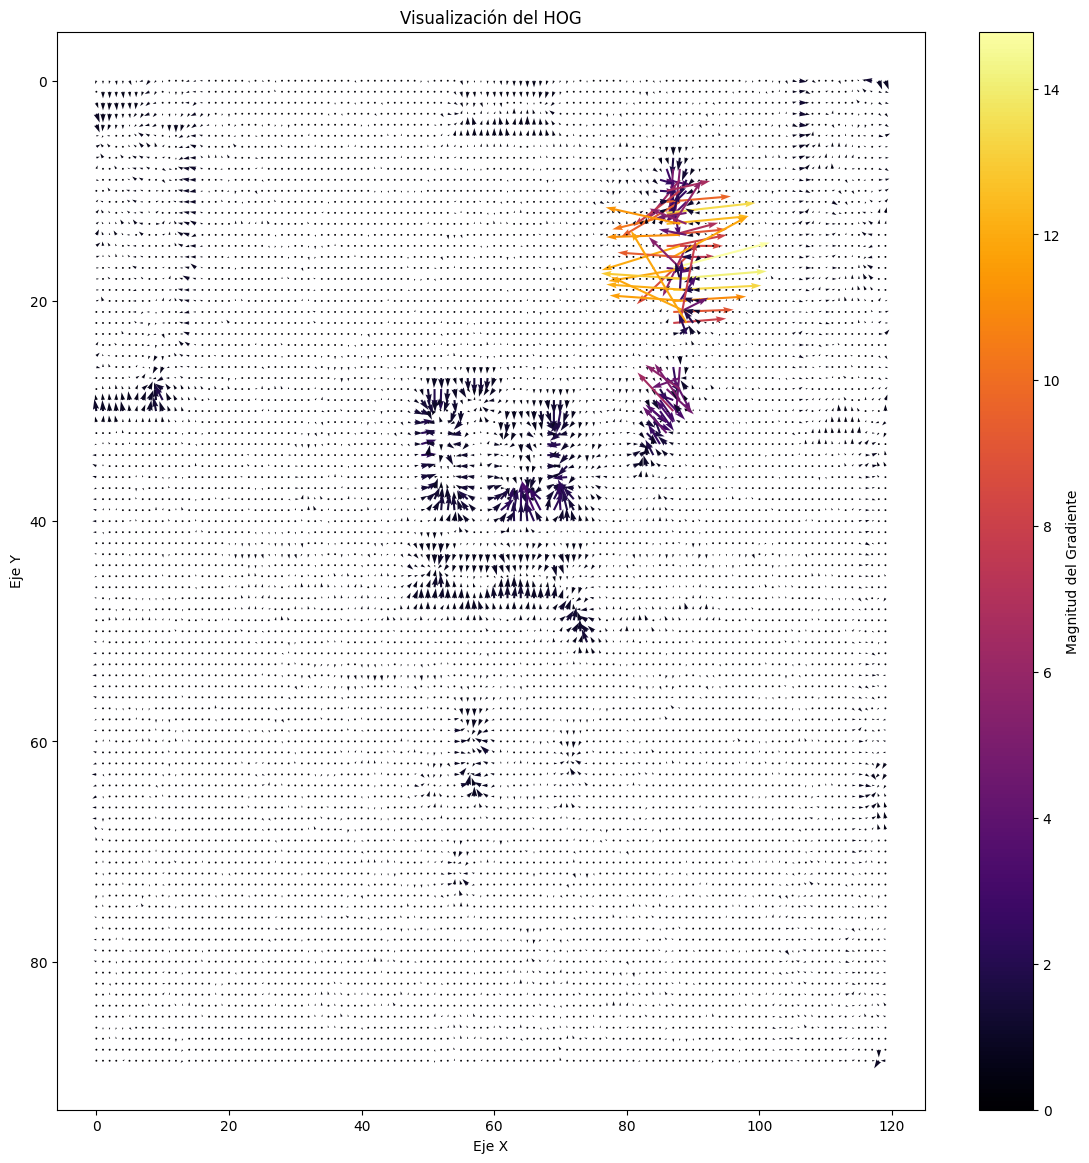





4. Filename: IR_01776.csv

DataFrame 4:



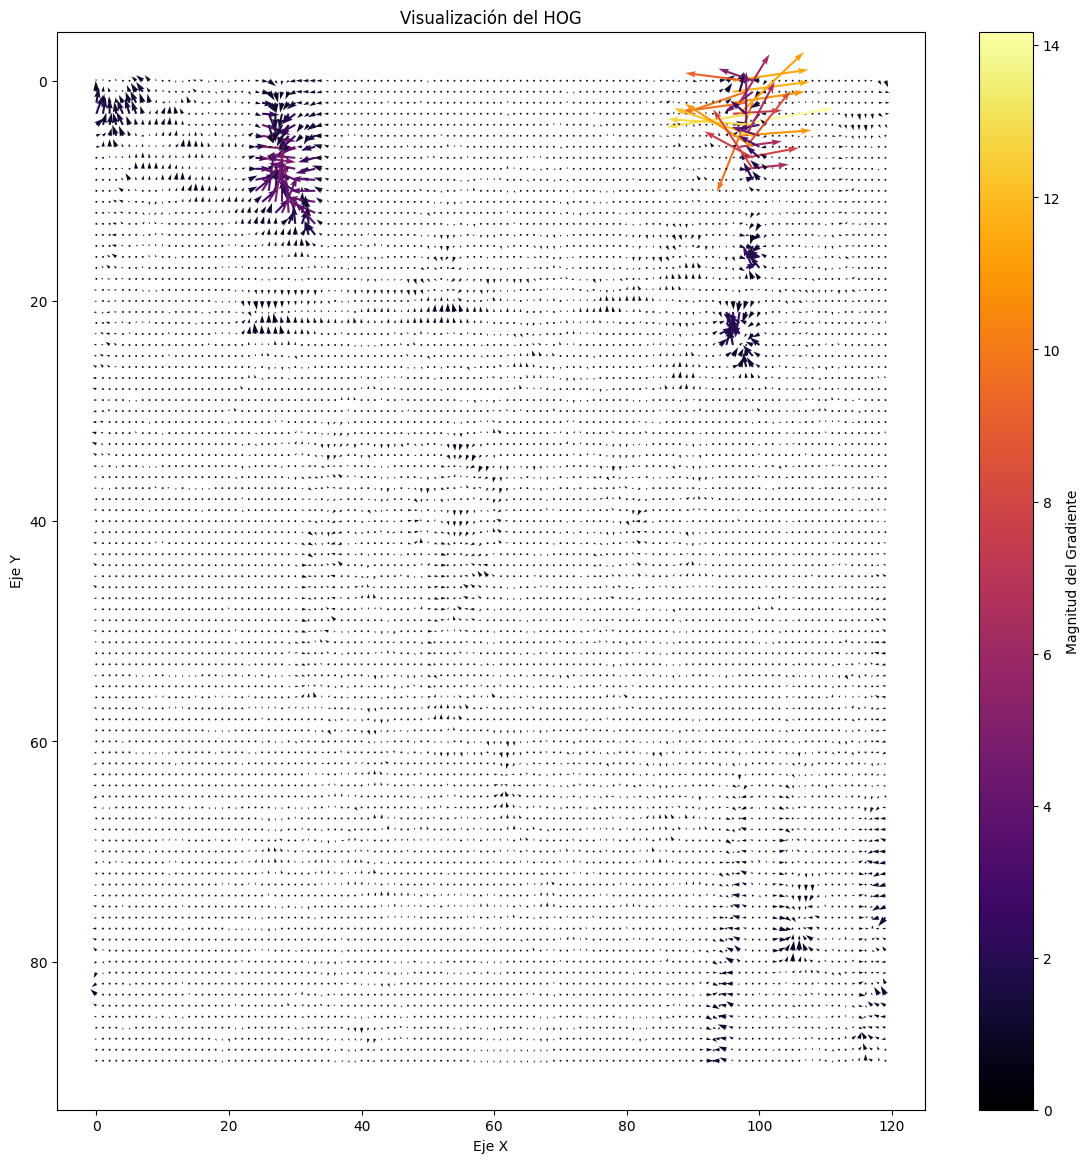





5. Filename: IR_00056.csv

DataFrame 5:



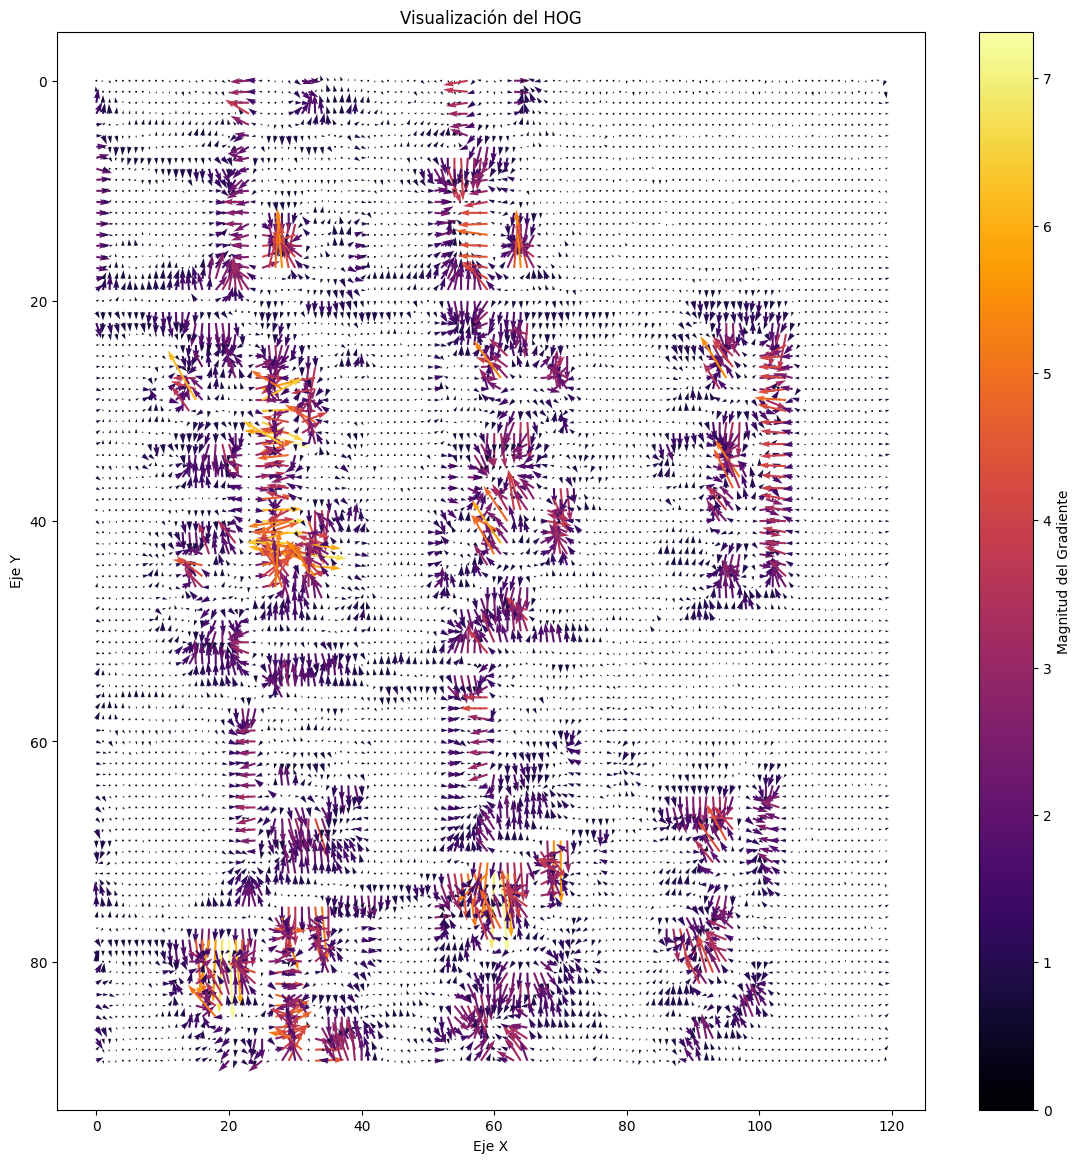

In [28]:
# Impresión de las visualizaciones de los HOG de los dataframes

# Iteración de los primeros 5 Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, Normal_Temp_Test[:5])):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Visualización del HOG del Dataframe
    HOV_df(Grad_Mag_Test[i], Grad_Dir_Test[i], 90, 120, 1)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

## **Algoritmos Seleccionados**

### **Modelo Base (Isolation Forest)**

Para abordar el problema de detección de anomalías en las mediciones de temperatura, se decidió hacer uso del modelo **Isolation Forest** con los valores obtenidos de las magnitudes y direcciones de los gradientes de temperatura obtenidos previamente como modelo base. Esto es debido a que este modelo permite obtener una métrica base para la detección de valores atípicos, objetivo principal de este proyecto, mediante la forma en la que opera.

El modelo de Bosque de Aislamiento, mejor conocido como **Isolation Forest**, opera detectando directamente las anomalías mediante un proceso iterativo relativamente sencillo:

* Se selecciona una variable (feature) de forma aleatoria.
* El conjunto de datos es dividido aleatoriamente en función de esta variable para obtener dos subconjuntos de estos.
* Los dos pasos anteriores se repiten hasta aislar solo un dato.
* Estos pasos se repiten de forma recursiva.

Este modelo encuentra varias similitudes con el modelo del Bosque Aleatorio, mejor conocido como **Random Forest**, ya que se crea un *bosque* formado por decenas o centenas de árboles, cuyos resultados son combinados para obtener un mejor resultado, lo cual es de enorme ayuda en el contexto general de este proyecto.

#### **Características importantes**

Para la implementación de este modelo en el conjunto de datos con el que se cuenta, se ha realizado el análisis correspondiente a la normalización de los datos y el cálculo de los componentes del gradiente de cada uno de los pixeles, los cuales contienen las mediciones de temperatura detectadas por el sensor, por cada uno de los archivos con las mediciones obtenidas.

Estos archivos corresponden a las temperaturas detectadas por el equipo de sensado, una cámara termográfica de la marca Fluke, las cuales son mostradas en forma de imágenes en la interfaz principal del equipo. Debido a esto, se implementan las técnicas anteriores y siguientes a los archivos obtenidos de las imágenes que fueron utilizadas para el entrenamiento y ejecución del modelo de visión que se pudo apreciar anteriormente en el documento.

In [29]:
# Inicialización de listas para almacenar resultados

# Listas de Valores Atípicos, Temperaturas ajustadas, Valores Normalizados y Totales
Outliers = []
Adjusted_Temps = []
Normal_Adjusted_Temps = []
Normal_Temps = []
Combined_Normal_Temps = []
Combined_Names = []

# Listas de Gradientes
Gradient_Mag = []
Gradient_Dir = []
Gradient_DirDeg = []
Gradient_Mag_N = []
Gradient_Dir_N = []
Gradient_DirDeg_N = []

Inicialmente, se normalizan todos los dataframes obtenidos de la lista de archivos .csv con las mediciones de temperatura que no forman parte de las anomalías.

In [30]:
# Normalización de los Dataframes
for i, (name, df) in enumerate(zip(proc_dataframe_names, processed_dataframes)):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Normalización de Dataframe y almacenamiento en la lista correspondiente
    temp_norm = normalization(df)
    Normal_Temps.append(temp_norm)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

Se han truncado las últimas 5000 líneas del flujo de salida.
283. Filename: IR_00050.csv

DataFrame 283:

Dataframe Normalizado:
          1         2         3         4         5         6         7    \
0  -0.049672 -0.061369 -0.057546 -0.109440 -0.249681 -0.404592 -0.515922   
1   0.350076  0.344244  0.336987  0.260724  0.107355 -0.037359 -0.126924   
2   0.995266  1.002115  0.966577  0.839069  0.655354  0.513237  0.443588   
3   1.586922  1.597600  1.535559  1.365384  1.152053  0.997829  0.917348   
4   1.967290  1.961582  1.875512  1.683489  1.454598  1.285018  1.171027   
..       ...       ...       ...       ...       ...       ...       ...   
85 -0.563224 -0.594641 -0.713485 -0.916528 -1.138268 -1.346883 -1.547472   
86 -0.587245 -0.627366 -0.759993 -0.977822 -1.200511 -1.390230 -1.554880   
87 -0.611632 -0.653122 -0.785777 -0.999662 -1.212815 -1.389920 -1.538133   
88 -0.683924 -0.707489 -0.818865 -1.010391 -1.201114 -1.365632 -1.515173   
89 -0.764468 -0.761732 -0.847465 -

Además de esto, se obtienen las matrices de datos atípicos con los dataframes correspondientes, se ajustan sus valores de temperatura y se normalizan todos los dataframes en la lista.

In [31]:
# Generación de dataframes de valores atípicos y ajuste (escalamiento) de los dataframes de outliers para maximizar su impacto

# Iteración en todos los Dataframes de valores atípicos
for i, (name, df) in enumerate(zip(proc_out_df_names, proc_out_df)):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Generación de Dataframe de Valores Atípicos y almacenamiento en la lista correspondiente
    outlier = outliers(df, df.mean().mean(), df.std().mean())
    Outliers.append(outlier)
    print("\n")

    # Aplicación de la máscara de valores atípicos al DataFrame original
    adjusted_temp, upper_rg, lower_rg = apply_outlier_mask(df, outlier, upper_factor_range, lower_factor_range)
    print(f"Upper Factor {i + 1}: {upper_rg}"+ "\n")
    print(f"Lower Factor {i + 1}: {lower_rg}"+ "\n")
    Adjusted_Temp_Test.append(adjusted_temp)

    # Normalización de Dataframe y almacenamiento en la lista correspondiente
    temp_norm = normalization(adjusted_temp)
    Normal_Adjusted_Temps.append(temp_norm)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

Se han truncado las últimas 5000 líneas del flujo de salida.

Lower Factor 146: 0.8745117640616402

Dataframe Normalizado:
          1         2         3         4         5         6         7    \
0   0.362359  0.338980  0.237872  0.023182 -0.355099 -0.756927 -1.025645   
1   0.340598  0.252571  0.086265 -0.158155 -0.488110 -0.801706 -0.991834   
2   0.356000  0.120804 -0.169323 -0.452491 -0.707992 -0.889339 -0.977401   
3   0.253858 -0.093768 -0.449004 -0.711308 -0.893708 -0.983116 -0.994941   
4   0.150246 -0.211708 -0.543159 -0.766579 -0.945303 -1.035152 -1.007592   
..       ...       ...       ...       ...       ...       ...       ...   
85  0.646074  0.433689  0.225687  0.053445 -0.103290 -0.105671  0.051941   
86  0.488681  0.331985  0.132657 -0.144966 -0.479086 -0.645363 -0.645934   
87  0.431088  0.323909  0.164566 -0.117133 -0.481232 -0.709499 -0.810890   
88  0.494315  0.368310  0.208764 -0.033594 -0.323714 -0.522538 -0.685800   
89  0.605854  0.424898  0.233669  0.0201

Por último, se concatenan ambos conjuntos (datos ajustados y datos originales) para conseguir un dataset con mayor impacto y un mejor balance de clases para su uso en los modelos posteriores.

In [32]:
# Creación de una lista combinada al juntar los Dataframes ajustados y sus nombres al conjunto de los originales
Combined_Normal_Temps = Normal_Temps + Normal_Adjusted_Temps
Combined_Names = proc_dataframe_names + proc_out_df_names

In [35]:
# Obtención de la máxima longitud entre todas las listas
max_len = max(len(Normal_Temps), len(Normal_Adjusted_Temps), len(Combined_Normal_Temps))

# Padding de cada lista hacia la máxima longitud
Normal_Temps += [None] * (max_len - len(Normal_Temps))
Normal_Adjusted_Temps += [None] * (max_len - len(Normal_Adjusted_Temps))
Combined_Normal_Temps += [None] * (max_len - len(Combined_Normal_Temps))

# Creación de un DataFrame con las listas
Temps_df = pd.DataFrame({'Lista1': Normal_Temps, 'Lista2': Normal_Adjusted_Temps, 'Lista3': Combined_Normal_Temps})

# Guardado del DataFrame a un archivo .csv
Temps_df.to_csv('Temps.csv', index=False)

Estos datos normalizados son utilizados para obtener los cálculos de las componentes de los gradientes de temperatura en las capturas térmicas.

**Gradientes de Dataframes Normalizados**

In [36]:
# Cálculos de Gradientes de los Dataframes Normalizados
for i, (name, df) in enumerate(zip(Combined_Names, Combined_Normal_Temps)):

    # Impresión del nombre del DataFrame
    print(f"{i + 1}. Filename: {name}"+ "\n")

    # Impresión del número de DataFrame
    print(f"DataFrame {i+1}:"+ "\n")

    # Operaciones con Gradientes y almacenamiento en la lista correspondiente
    grad_mag, grad_dir, grad_dirdeg = gradient_comps(df)
    Gradient_Mag_N.append(grad_mag)
    Gradient_Dir_N.append(grad_dir)
    Gradient_DirDeg_N.append(grad_dirdeg)
    print("\n")

    # Separador entre los Dataframes para mejor lectura
    print("\n" + "="*80 + "\n")

Se han truncado las últimas 5000 líneas del flujo de salida.
 [ 0.15947702  0.12696091  0.12463495 ...  0.0203133   0.04186832
   0.03562952]
 [ 0.07429567  0.05236486  0.05373958 ... -0.03920682 -0.05137669
  -0.05847404]
 ...
 [-0.21541128 -0.11253989  0.04886694 ... -0.05522148 -0.07669897
  -0.14099259]
 [-0.53920345 -0.4759395  -0.41104525 ... -0.03943674 -0.04079928
  -0.06799224]
 [-0.53920345 -0.4759395  -0.41104525 ... -0.03943674 -0.04079928
  -0.06799224]]

Magnitud del Gradiente por Pixel:
 [[0.10210045 0.09211021 0.11054256 ... 0.13630848 0.1435837  0.1350426 ]
 [0.16009846 0.12713326 0.12919127 ... 0.10886477 0.15810635 0.15656987]
 [0.07654594 0.05312314 0.05736885 ... 0.09396786 0.1668098  0.1691306 ]
 ...
 [0.25294945 0.181074   0.09750244 ... 0.24395103 0.29086476 0.31400395]
 [0.54002208 0.47634097 0.42286008 ... 0.21970962 0.2200911  0.22671228]
 [0.54024562 0.48337326 0.44491979 ... 0.21836934 0.19343515 0.20093661]]

Dirección del Gradiente (radianes) por Pixel:
 

El haber llevado a cabo los cálculos anteriores permite obtener un mejor entendimiento de las fronteras entre los diferentes puntos de la imagen al momento de que existan cambios relevantes de temperatura, en este caso.

Al tener un conjunto de datos efectivamente filtrado al trabajar con normalizaciones, los modelos podrán ser ejecutados con una mayor rapidez y eficiencia, además de permitir observar diferentes comportamientos y patrones a lo largo de los conjuntos de datos que se tienen con una mejor efectividad.

Para comenzar con la implementación del modelo de aprendizaje no supervisado, se busca asegurar que las dimensiones de los arreglos que contienen las magnitudes y direcciones de los gradientes (obtenidos con los datos normalizados y no normalizados) sean del mismo tamaño, para no tener errores en la implementación del modelo.

In [37]:
# Asegurado que ambas listas de componentes de los gradientes tienen la misma longitud
assert len(Gradient_Mag_N) == len(Gradient_Dir_N)

Debido a que se cuenta con varias listas de Dataframes en dos dimensiones, con información diferente correspondiente a un mismo cálculo, se decidió aplanarlos y combinar ambos vectores aplanados por Dataframe para obtener un solo vector con características representativas.

In [38]:
# Inicialización de una lista para almacenamiento de las características
features = []

In [39]:
# Aplanado de los datos y creación de características combinadas

for mag_df, dir_df in zip(Gradient_Mag_N, Gradient_Dir_N):

    # Aplanado de cada DataFrame de dos dimensiones hacia arreglos de una dimensión
    mag_flat = mag_df.flatten()
    dir_flat = dir_df.flatten()

    # Concatenado de magnitud y dirección aplanada a un vector de características singular
    combined_features = np.hstack((mag_flat, dir_flat))

    # Almacenamiento del vector de características en la lista
    features.append(combined_features)

In [40]:
# Conversión de la lista de características a un arreglo de dos dimensiones (filas = instancias, columnas = características)
features = np.array(features)
print("Forma de la matriz de características:", features.shape)

Forma de la matriz de características: (570, 21600)


La forma de la matriz de características obtenida, corresponde a la siguiente ecuación, considerando **N** Dataframes de forma **(m,n)**:



```
# (N, 2*m*n)
```


Esto es debido a que cada Dataframe contribuye su magnitud y dirección, aplanados en un vector sencillo.

El valor 21600 corresponde 2 veces 10,800, la cual es la cantidad de pixeles en la imagen y cuyas temperaturas son registradas por los archivos .csv.

Debido a que se cuenta con un vector con alta dimensionalidad, se aplica PCA para poder obtener solo las características más importantes.

Se usa arbitrariamente la medida para mantener el 95% de la varianza explicada y se imprimen las formas de los vectores características para apreciar el efecto de la reducción de dimensionalidad.

In [41]:
# Aplicación de PCA, manteniendo el 95% de la varianza explicada
pca = PCA(n_components=0.95)
redux_feat = pca.fit_transform(features)

In [42]:
# Impresión de la forma original del vector de características y la forma reducida por PCA
print(f"Original shape: {features.shape}, Reduced shape: {redux_feat.shape}")

Original shape: (570, 21600), Reduced shape: (570, 340)


## **Creación de archivo**

In [43]:
# Conversión de arreglo a un DataFrame
redux_feat_df = pd.DataFrame(redux_feat)

# Impresión de los primeros 5 renglones para observar la forma y contenido de las características
redux_feat_df.head()

0          1          2          3          4          5    \
0  13.619215 -28.368866  -4.641301  39.854276  14.469394 -28.029995   
1 -14.981461  12.924725 -31.355194  -5.693090  11.192531  14.858262   
2 -21.819164  15.219118  -7.034432  -8.194918  -3.286706  -4.689369   
3   5.346421 -13.386869  -8.126881  -6.841140  22.729405 -23.392195   
4 -28.007070  25.832986 -11.889654  20.691078   7.494503  12.529279   

         6          7          8          9    ...        330        331  \
0   8.336688 -43.917642  -9.132295 -39.692596  ...   0.618312  -0.443933   
1 -11.529182  20.552588 -12.258721   9.972517  ... -10.773378 -15.962186   
2  11.724734  -8.828571  -7.406875   9.811203  ...  -1.172987   1.320788   
3  -9.667467  -1.681006  -0.791361 -26.861628  ...  -5.318121  13.347697   
4 -16.452148  16.631531   5.491198  -1.005151  ...   2.658343  -0.590277   

         332        333       334       335       336        337       338  \
0   2.401926  -1.075673 -1.315966  2.249089 -0.058382  -0.166673 -2.026209   
1   1.708921  -9.994359  1.963965  3.790790  2.948565  -9.740288  1.796670   
2  -0.026237  -0.748166 -0.350792  1.830717  1.921400   1.668043 -0.911252   
3   0.279716   2.542566  0.881720 -2.256603  2.318870   7.646979 -0.394943   
4  11.653845 -11.104867 -1.631507  1.125982  5.539170  11.788264 -1.172949   

         339  
0   1.740528  
1 -11.859130  
2   5.450081  
3   3.334717  
4   7.146674  

[5 rows x 340 columns]

In [44]:
# Guardado del Dataframe con características reducido a un archivo .csv
redux_feat_df.to_csv('redux_feat.csv', index=False)